




# ===============================
# Step 1: Import Libraries
# ===============================

In [220]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.cm as cm
import matplotlib.colors as mcolors


# Statistical Testing
from scipy import stats
from scipy.stats import (
    mannwhitneyu, chi2_contingency, ttest_ind,
    ks_2samp, pearsonr, spearmanr,
    chi2, f_oneway, kruskal
)

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.multitest import multipletests
from scipy.stats import fisher_exact

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, classification_report,
    confusion_matrix, precision_recall_curve, f1_score
)

# Advanced Statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.power import ttest_power
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Set style
plt.style.use('default')
sns.set_palette("husl")


# ===============================
# Step 2: Load and Explore Data
# ===============================

In [221]:

def load_and_explore_data():
    """
    טוען ובוחן את הנתונים הראשוניים
    """
    print("=== Loading Adult Income Dataset ===")

    # Column names based on the Kaggle dataset
    column_names = [
        'age', 'workclass', 'fnlwgt', 'education', 'educational-num',
        'marital-status', 'occupation', 'relationship', 'race', 'gender',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
    ]

    # Load from URL (can be changed to local file path)
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

    try:
        df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)
        print("Data loaded successfully from UCI repository")
    except:
        print("Could not load from URL. Please load from local file.")
        # For local file loading:
        # df = pd.read_csv('adult.data', names=column_names, na_values=' ?', skipinitialspace=True)
        return None

    print(f"Dataset shape: {df.shape}")
    print(f"Missing values per column:")
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print(missing_values[missing_values > 0])
    else:
        print("No missing values found!")

    return df

def basic_data_exploration(df):
    """
    ניתוח ראשוני של הנתונים
    """
    print("\n=== Basic Data Exploration ===")

    # Basic info
    print(f"Dataset shape: {df.shape}")
    print(f"\nData types:")
    print(df.dtypes)

    # Target variable distribution
    print(f"\nIncome distribution:")
    print(df['income'].value_counts())
    print(f"Percentage earning >50K: {(df['income'] == '>50K').mean():.2%}")

    # Check unique values in categorical columns
    categorical_cols = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'gender', 'native-country']

    for col in categorical_cols:
        if col in df.columns:
            print(f"\n{col} unique values ({df[col].nunique()}): ")
            print(df[col].value_counts().head())

    return df

# ===============================
# Step 3: Data Preprocessing
# ===============================

In [222]:


def preprocess_data(df):
    """
    עיבוד וניקוי הנתונים
    """
    print("\n=== Data Preprocessing ===")

    # Create a copy
    df_clean = df.copy()

    # Handle missing values
    print(f"Rows before cleaning: {len(df_clean)}")
    df_clean = df_clean.dropna()
    print(f"Rows after cleaning: {len(df_clean)}")

    # Create binary target variable
    df_clean['income_binary'] = (df_clean['income'] == '>50K').astype(int)

    # Fix column names to match Python naming conventions
    df_clean.columns = [col.replace('-', '_') for col in df_clean.columns]

    # 1. Simplify marital status
    marital_mapping = {
        'Never-married': 'Single',
        'Married-civ-spouse': 'Married',
        'Married-spouse-absent': 'Separated',
        'Married-AF-spouse': 'Married',
        'Divorced': 'Divorced',
        'Separated': 'Separated',
        'Widowed': 'Widowed'
    }
    df_clean['marital_simple'] = df_clean['marital_status'].map(marital_mapping)

    # 2. Create age groups
    age_bins = [16, 25, 35, 45, 55, 65, 100]
    age_labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
    df_clean['age_group'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels, right=False)

    # 3. Simplify education
    education_mapping = {
        'Preschool': 'No-HS',
        '1st-4th': 'No-HS',
        '5th-6th': 'No-HS',
        '7th-8th': 'No-HS',
        '9th': 'No-HS',
        '10th': 'No-HS',
        '11th': 'No-HS',
        '12th': 'No-HS',
        'HS-grad': 'HS-grad',
        'Some-college': 'Some-college',
        'Assoc-acdm': 'Associates',
        'Assoc-voc': 'Associates',
        'Bachelors': 'Bachelors',
        'Masters': 'Advanced',
        'Prof-school': 'Advanced',
        'Doctorate': 'Advanced'
    }
    df_clean['education_simple'] = df_clean['education'].map(education_mapping)

    # 4. Simplify workclass
    workclass_mapping = {
        'Private': 'Private',
        'Self-emp-not-inc': 'Self-employed',
        'Self-emp-inc': 'Self-employed',
        'Local-gov': 'Government',
        'State-gov': 'Government',
        'Federal-gov': 'Government',
        'Without-pay': 'Other',
        'Never-worked': 'Other'
    }
    df_clean['workclass_simple'] = df_clean['workclass'].map(workclass_mapping)

    # 5. Group occupation into broader categories
    management_prof = [
        'Exec-managerial', 'Prof-specialty', 'Tech-support'
    ]
    service_sales = [
        'Sales', 'Other-service', 'Protective-serv', 'Priv-house-serv'
    ]
    blue_collar = [
        'Craft-repair', 'Machine-op-inspct', 'Transport-moving',
        'Handlers-cleaners', 'Farming-fishing'
    ]
    support = [
        'Adm-clerical', 'Armed-Forces'
    ]

    def categorize_occupation(occ):
        if occ in management_prof:
            return 'Management/Professional'
        elif occ in service_sales:
            return 'Service/Sales'
        elif occ in blue_collar:
            return 'Blue-collar'
        elif occ in support:
            return 'Support'
        else:
            return 'Other'

    df_clean['occupation_group'] = df_clean['occupation'].apply(categorize_occupation)

    # 6. Create capital investment indicators
    df_clean['has_capital_gain'] = (df_clean['capital_gain'] > 0).astype(int)
    df_clean['has_capital_loss'] = (df_clean['capital_loss'] > 0).astype(int)
    df_clean['net_capital'] = df_clean['capital_gain'] - df_clean['capital_loss']
    df_clean['has_investments'] = ((df_clean['capital_gain'] > 0) |
                                   (df_clean['capital_loss'] > 0)).astype(int)

    # 7. Create work intensity categories
    work_hour_bins = [0, 35, 40, 50, 100]
    work_hour_labels = ['Part-time', 'Standard', 'Full-time+', 'Intensive']
    df_clean['work_intensity'] = pd.cut(df_clean['hours_per_week'],
                                        bins=work_hour_bins,
                                        labels=work_hour_labels,
                                        right=False)

    print("\nNew features created:")
    print("- income_binary: Binary target (1 = >50K)")
    print("- marital_simple: Simplified marital status")
    print("- age_group: Age categories")
    print("- education_simple: Education level groups")
    print("- workclass_simple: Employment type")
    print("- occupation_group: Broad occupation categories")
    print("- has_investments: Investment activity indicator")
    print("- work_intensity: Work hours categories")

    return df_clean

 # ===============================
# Step 4: Exploratory Data Analysis
# ===============================

In [223]:


def create_comprehensive_visualizations(df):
    """
    יוצר ויזואליזציות מקיפות לניתוח ראשוני
    """
    print("\n=== Creating Comprehensive Visualizations ===")

    # Set style for professional plots
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 12

    # 1. Income distribution by key demographics
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle('Income Distribution by Key Demographics', fontsize=16, fontweight='bold')

    # Gender
    pd.crosstab(df['gender'], df['income'], normalize='index').plot(
        kind='bar', ax=axes[0], color=['lightcoral', 'skyblue']
    )
    axes[0].set_title('Income by Gender')
    axes[0].set_ylabel('Proportion')
    axes[0].tick_params(axis='x', rotation=0)

    # Age groups
    pd.crosstab(df['age_group'], df['income'], normalize='index').plot(
        kind='bar', ax=axes[1], color=['lightcoral', 'skyblue']
    )
    axes[1].set_title('Income by Age Group')
    axes[1].tick_params(axis='x', rotation=45)

    # Marital status
    pd.crosstab(df['marital_simple'], df['income'], normalize='index').plot(
        kind='bar', ax=axes[2], color=['lightcoral', 'skyblue']
    )
    axes[2].set_title('Income by Marital Status')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 2. Gender-Marital Status Interaction Analysis
    fig, axe = plt.subplots()
    # Create interaction variable
    df['gender_marital'] = df['gender'] + ' - ' + df['marital_simple']

    # Plot 1: Income rates by gender-marital combination
    income_by_combo = df.groupby('gender_marital')['income_binary'].agg(['mean', 'count'])
    income_by_combo = income_by_combo[income_by_combo['count'] >= 50]  # Filter small groups

    # יצירת colormap מתוך viridis
    cmap = cm.get_cmap('viridis', len(income_by_combo))

    # שימוש בצבעים מה־colormap
    colors = [cmap(i) for i in range(len(income_by_combo))]

    income_by_combo['mean'].plot(kind='bar', ax=axe, color=colors)

    axe.set_title('Income >50K Rate by Gender-Marital Status')
    axe.set_ylabel('Proportion earning >50K')
    axe.tick_params(axis='x', rotation=45)
    axe.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df



# ===============================
# Step 5: Statistical Analysis -
# ===============================



In [224]:
def comprehensive_statistical_analysis(df):
    """
    ניתוח סטטיסטי מקיף עם כל המבחנים הנדרשים
    """
    print("\n=== Comprehensive Statistical Analysis ===")

    results = {}

    # === PART 1: Normality Testing ===
    print("\n1. NORMALITY TESTING (Kolmogorov-Smirnov)")
    numerical_cols = ['age', 'educational_num', 'hours_per_week', 'capital_gain', 'capital_loss']

    normality_results = {}
    for col in numerical_cols:
        if col in df.columns:
            stat, p_val = stats.kstest(df[col], 'norm')
            normality_results[col] = {'statistic': stat, 'p_value': p_val, 'is_normal': p_val > 0.05}
            print(f"{col}: KS-statistic = {stat:.4f}, p-value = {p_val:.2e}, Normal: {p_val > 0.05}")

    results['normality'] = normality_results

    # === PART 2: Feature Distribution Analysis ===
    print("\n2. FEATURE DISTRIBUTION ANALYSIS")

    # Separate groups for analysis
    high_income = df[df['income_binary'] == 1]
    low_income = df[df['income_binary'] == 0]

    distribution_results = {}

    # Mann-Whitney U test for numerical features (non-parametric)
    print("\nMann-Whitney U Test Results:")
    for col in numerical_cols:
        if col in df.columns:
            u_stat, p_val = mannwhitneyu(high_income[col], low_income[col], alternative='two-sided')
            # Calculate Cohen's d for effect size
            pooled_std = np.sqrt(((len(high_income[col])-1)*np.var(high_income[col], ddof=1) +
                                 (len(low_income[col])-1)*np.var(low_income[col], ddof=1)) /
                                (len(high_income[col]) + len(low_income[col]) - 2))
            effect_size = (np.mean(high_income[col]) - np.mean(low_income[col])) / pooled_std

            distribution_results[col] = {
                'test': 'Mann-Whitney U',
                'statistic': u_stat,
                'p_value': p_val,
                'effect_size': effect_size,
                'significant': p_val < 0.05
            }
            print(f"{col}: U = {u_stat:.1f}, p = {p_val:.2e}, Cohen's d = {effect_size:.3f}")

    # Chi-square test for categorical features
    print("\nChi-square Test Results:")
    categorical_cols = ['gender', 'marital_simple', 'education_simple', 'workclass_simple',
                       'occupation_group', 'race', 'age_group', 'work_intensity']

    for col in categorical_cols:
        if col in df.columns and df[col].notna().sum() > 0:
            contingency = pd.crosstab(df[col], df['income_binary'])
            chi2_stat, p_val, dof, expected = chi2_contingency(contingency)

            # Calculate Cramer's V (effect size for categorical)
            n = contingency.sum().sum()
            cramers_v = np.sqrt(chi2_stat / (n * (min(contingency.shape) - 1)))

            distribution_results[col] = {
                'test': 'Chi-square',
                'statistic': chi2_stat,
                'p_value': p_val,
                'cramers_v': cramers_v,
                'significant': p_val < 0.05
            }
            print(f"{col}: χ² = {chi2_stat:.2f}, p = {p_val:.2e}, Cramer's V = {cramers_v:.3f}")

    results['distributions'] = distribution_results

    # === PART 3: Multiple Testing Correction ===
    print("\n3. MULTIPLE TESTING CORRECTION (Benjamini-Hochberg FDR)")

    p_values = [result['p_value'] for result in distribution_results.values()]
    feature_names = list(distribution_results.keys())

    rejected, corrected_p, alpha_sidak, alpha_bonf = multipletests(
        p_values, alpha=0.05, method='fdr_bh'
    )

    print("Significant features after FDR correction:")
    for i, (feature, is_significant) in enumerate(zip(feature_names, rejected)):
        if is_significant:
            original_p = p_values[i]
            corrected_p_val = corrected_p[i]
            print(f"  {feature}: Original p = {original_p:.2e}, Corrected p = {corrected_p_val:.2e}")

    results['multiple_testing'] = {
        'corrected_p_values': corrected_p,
        'significant_features': [f for f, sig in zip(feature_names, rejected) if sig]
    }

    return results

def gender_marital_analysis(df):
    """
    ניתוח מעמיק של פערי מגדר ומצב משפחתי
    """
    print("\n=== Gender and Marital Status Analysis ===")

    results = {}

    # === ANALYSIS 1: Married Male vs Married Female ===
    print("\n1. MARRIED MALE vs MARRIED FEMALE ANALYSIS")

    married_male = df[(df['gender'] == 'Male') & (df['marital_simple'] == 'Married')]
    married_female = df[(df['gender'] == 'Female') & (df['marital_simple'] == 'Married')]

    # Proportions test
    count_male = married_male['income_binary'].sum()
    count_female = married_female['income_binary'].sum()
    nobs_male = len(married_male)
    nobs_female = len(married_female)

    # Two-proportion z-test
    z_stat, p_val = proportions_ztest([count_male, count_female], [nobs_male, nobs_female], alternative='larger' )

    # Effect size (difference in proportions)
    prop_male = count_male / nobs_male
    prop_female = count_female / nobs_female
    effect_size = prop_male - prop_female

    # Confidence intervals for each group's proportion
    ci_low_male, ci_upp_male = proportion_confint(count_male, nobs_male, alpha=0.05, method='normal')
    ci_low_female, ci_upp_female = proportion_confint(count_female, nobs_female, alpha=0.05, method='normal')

    # Confidence interval for the difference in proportions
    # Standard error for the difference
    se_diff = np.sqrt(prop_male * (1 - prop_male) / nobs_male +
                      prop_female * (1 - prop_female) / nobs_female)
    z_crit = 1.96  # for 95% CI
    diff_low = effect_size - z_crit * se_diff
    diff_upp = effect_size + z_crit * se_diff

    print(f"Married Male high income rate: {prop_male:.3f} ({count_male}/{nobs_male})")
    print(f"Married Female high income rate: {prop_female:.3f} ({count_female}/{nobs_female})")
    print(f"Difference: {effect_size:.3f}")
    print(f"Z-statistic: {z_stat:.3f}, p-value: {p_val:.4f}")
    print(f"Difference 95% CI: ({diff_low:.3f}, {diff_upp:.3f})")


    results['married_gender_comparison'] = {
        'male_rate': prop_male,
        'female_rate': prop_female,
        'difference': effect_size,
        'z_statistic': z_stat,
        'p_value': p_val,
        'significant': p_val < 0.05
    }

    # === ANALYSIS 2: Overall Gender Comparison ===
    print("\n2. OVERALL GENDER COMPARISON")

    male_income = df[df['gender'] == 'Male']['income_binary']
    female_income = df[df['gender'] == 'Female']['income_binary']

    # One-proportion z-test
    count_male_all = male_income.sum()
    count_female_all = female_income.sum()
    nobs_male_all = len(male_income)
    nobs_female_all = len(female_income)

    z_stat_all, p_val_all = proportions_ztest([count_male_all, count_female_all],
                                              [nobs_male_all, nobs_female_all], alternative='larger' )

    prop_male_all = count_male_all / nobs_male_all
    prop_female_all = count_female_all / nobs_female_all
    effect_size_all = prop_male_all - prop_female_all


    # Means (proportions) for binary data
    mean_male = prop_male_all  # already computed
    mean_female = prop_female_all

    # Standard deviations for binary data
    sd_male = (mean_male * (1 - mean_male)) ** 0.5
    sd_female = (mean_female * (1 - mean_female)) ** 0.5

    # Pooled standard deviation
    pooled_sd = (((nobs_male_all - 1) * sd_male**2 +
                  (nobs_female_all - 1) * sd_female**2) /
                (nobs_male_all + nobs_female_all - 2)) ** 0.5

    # Cohen's d
    cohen_d = (mean_male - mean_female) / pooled_sd

    print(f"Male high income rate: {prop_male_all:.3f}")
    print(f"Female high income rate: {prop_female_all:.3f}")
    print(f"Difference: {effect_size_all:.3f}")
    print(f"Z-statistic: {z_stat_all:.3f}, p-value: {p_val_all:.4f}")
    print(f"Cohen's d: {cohen_d:.3f}")

    results['overall_gender_comparison'] = {
        'male_rate': prop_male_all,
        'female_rate': prop_female_all,
        'difference': effect_size_all,
        'z_statistic': z_stat_all,
        'p_value': p_val_all,
        'significant': p_val_all < 0.05
    }

 # === ANALYSIS 3: Unmarried  Male vs Unmarried Female Comparison ===
    print("\n3. Unmarrie Male vs Unmarried Female Comparison")

    unmarried_male = df[(df['gender'] == 'Male') & (df['marital_simple'] != 'Married')]
    unmarried_female = df[(df['gender'] == 'Female') & (df['marital_simple'] != 'Married')]

    # Proportions test
    count_male = unmarried_male['income_binary'].sum()
    count_female = unmarried_female['income_binary'].sum()
    nobs_male = len(unmarried_male)
    nobs_female = len(unmarried_female)

    # Two-proportion z-test
    z_stat, p_val = proportions_ztest([count_male, count_female], [nobs_male, nobs_female], alternative='larger' )

    # Effect size (difference in proportions)
    prop_male = count_male / nobs_male
    prop_female = count_female / nobs_female
    effect_size = prop_male - prop_female

    # Means (proportions) for binary data
    mean_male = prop_male  # already computed
    mean_female = prop_female

    # Standard deviations for binary data
    sd_male = (mean_male * (1 - mean_male)) ** 0.5
    sd_female = (mean_female * (1 - mean_female)) ** 0.5

    # Pooled standard deviation
    pooled_sd = (((nobs_male - 1) * sd_male**2 +
                  (nobs_female - 1) * sd_female**2) /
                (nobs_male + nobs_female - 2)) ** 0.5

    # Cohen's d
    cohen_d = (mean_male - mean_female) / pooled_sd


    print(f"Unmarried Male high income rate: {prop_male:.3f}")
    print(f"Unmarried Female high income rate: {prop_female:.3f}")
    print(f"Difference: {effect_size:.3f}")
    print(f"Z-statistic: {z_stat:.3f}, p-value: {p_val:.4f}")
    print(f"Cohen's d: {cohen_d:.3f}")

    results['Unmarrie_Male_vs_Unmarried_Female_Comparison'] = {
        'Unmarried male_rate': prop_male,
        'Unmarried female_rate': prop_female,
        'difference': effect_size,
        'z_statistic': z_stat,
        'p_value': p_val,
        'significant': p_val < 0.05
    }


    # === ANALYSIS 4: Age-Gender-Marital Interaction ===
    print("\n4. AGE-GENDER-MARITAL INTERACTION ANALYSIS")

    # Create interaction groups
    interaction_analysis = []

    for age_group in df['age_group'].unique():
        if pd.isna(age_group):
            continue

        for gender in ['Male', 'Female']:
            for marital in ['Married', 'Single']:
                subset = df[(df['age_group'] == age_group) &
                           (df['gender'] == gender) &
                           (df['marital_simple'] == marital)]

                if len(subset) >= 30:  # Minimum sample size
                    high_income_rate = subset['income_binary'].mean()
                    count = len(subset)
                    high_income_count = subset['income_binary'].sum()

                    interaction_analysis.append({
                        'age_group': age_group,
                        'gender': gender,
                        'marital_status': marital,
                        'sample_size': count,
                        'high_income_count': high_income_count,
                        'high_income_rate': high_income_rate
                    })

    interaction_df = pd.DataFrame(interaction_analysis)

    # Find the most striking differences
    print("Age-Gender-Marital Interaction Results (sample size >= 30):")
    interaction_df_sorted = interaction_df.sort_values('high_income_rate', ascending=False)
    print(interaction_df_sorted.to_string(index=False))

    results['interaction_analysis'] = interaction_df

    return results

def power_analysis(df):
    """
    ניתוח עוצמה סטטיסטי
    """
    print("\n=== Statistical Power Analysis ===")

    # Power analysis for gender comparison
    male_income = df[df['gender'] == 'Male']['income_binary']
    female_income = df[df['gender'] == 'Female']['income_binary']

    # Calculate effect size
    prop_diff = male_income.mean() - female_income.mean()

    # Calculate power for current sample size
    n1, n2 = len(male_income), len(female_income)
    power = ttest_power(prop_diff, n1, alpha=0.05, alternative='two-sided')

    print(f"Power Analysis for Gender Comparison:")
    print(f"Effect size (difference in proportions): {prop_diff:.4f}")
    print(f"Sample sizes: Male = {n1}, Female = {n2}")
    print(f"Statistical power: {power:.4f}")
    print(f"Power interpretation: {'Adequate' if power >= 0.8 else 'Inadequate'} (>= 0.8 is good)")

    return {'power': power, 'effect_size': prop_diff}


# ===============================
# Step 6: Machine Learning Models
# ===============================

In [225]:
def prepare_ml_data(df):
    """
    הכנת נתונים למודלי למידת מכונה
    """
    print("\n=== Preparing Data for Machine Learning ===")

    # Select features for ML
    numerical_features = ['age', 'educational_num', 'hours_per_week', 'capital_gain', 'capital_loss']
    categorical_features = ['workclass_simple', 'education_simple', 'marital_simple',
                           'occupation_group', 'gender', 'race']

    # Create feature matrix
    X_num = df[numerical_features].copy()
    X_cat = df[categorical_features].copy()

    # המרה ל-One-Hot Encoding
    X_cat_onehot = pd.get_dummies(X_cat, columns=categorical_features, drop_first=True)


    #  --- תיקנון של הפיצ'רים המספריים ---
    scaler = StandardScaler()
    X_num_scaled = pd.DataFrame(
        scaler.fit_transform(X_num),
        columns=numerical_features,
        index=X_num.index
    )

    # Combine features
    X = pd.concat([X_num_scaled, X_cat_onehot], axis=1)
    y = df['income_binary']

    print(f"Feature matrix shape: {X.shape}")
    print(f"Features: {list(X.columns)}")

    return X, y

def train_multiple_models(X, y):
    """
    אימון מודלים מרובים והשוואת ביצועים
    """
    print("\n=== Training Multiple ML Models ===")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
    }

    results = {}

    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Use scaled data for Logistic Regression, original for Random Forest
        if name == 'Logistic Regression':
            model.fit(X_train_scaled, y_train)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        auc_score = roc_auc_score(y_test, y_pred_proba)

        results[name] = {
            'model': model,
            'auc_score': auc_score,
            'y_pred_proba': y_pred_proba
        }

        print(f"{name} AUC Score: {auc_score:.4f}")

        # Feature importance for Random Forest
        if name == 'Random Forest':
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            print(f"\nTop 10 Feature Importances ({name}):")
            print(feature_importance.head(10).to_string(index=False))
            results[name]['feature_importance'] = feature_importance

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {result['auc_score']:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return results, X_test, y_test, scaler

def advanced_model_interpretation(models_results, X, y):
    """
    פרשנות מתקדמת של המודלים
    """
    print("\n=== Advanced Model Interpretation ===")

    # Get best model
    best_model_name = max(models_results.keys(), key=lambda x: models_results[x]['auc_score'])
    best_model = models_results[best_model_name]['model']

    print(f"Best performing model: {best_model_name}")

    # Detailed analysis for Random Forest (if it's the best or available)
    if 'Random Forest' in models_results:
        rf_model = models_results['Random Forest']['model']
        feature_importance = models_results['Random Forest']['feature_importance']

        # Plot feature importance
        plt.figure(figsize=(10, 8))
        top_features = feature_importance.head(10)
        sns.barplot(data=top_features, x='importance', y='feature')
        plt.title('Top 10 Feature Importances - Random Forest')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

        # Feature importance by category
        print("\nFeature Importance Analysis:")
        for idx, row in feature_importance.head(10).iterrows():
            print(f"{row['feature']}: {row['importance']:.4f}")

    # Logistic Regression Coefficients
    if 'Logistic Regression' in models_results:
        lr_model = models_results['Logistic Regression']['model']

        coefficients = pd.DataFrame({
            'feature': X.columns,
            'coefficient': lr_model.coef_[0],
            'abs_coefficient': np.abs(lr_model.coef_[0])
        }).sort_values('abs_coefficient', ascending=False)

        print(f"\nLogistic Regression - Top 10 Coefficients:")
        print(coefficients.head(10)[['feature', 'coefficient']].to_string(index=False))

        # Plot coefficients
        plt.figure(figsize=(10, 8))
        top_coef = coefficients.head(10)

        num_colors = len(top_coef)
        colors = sns.cubehelix_palette(n_colors=num_colors, gamma=.5)

        sns.barplot(data=top_coef, x='coefficient', y='feature', palette=colors)
        plt.title('Top 10 Logistic Regression Coefficients')
        plt.xlabel('Coefficient Value')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    return best_model_name, best_model


# ===============================
# Step 7: Advanced Statistical Tests
# ===============================


In [226]:
def advanced_statistical_tests(df):
    """
    מבחנים סטטיסטיים מתקדמים נוספים
    """
    print("\n=== Advanced Statistical Tests ===")
    results = {}

    # === Two-Proportion Z-Tests for Each Age Group (Men vs Women Income) ===
    print("\nTWO-PROPORTION Z-TESTS - Men vs Women Income by Age Group")

    age_group_results = {}

    for age_group in df['age_group'].unique():
        if pd.notna(age_group):
            group_data = df[df['age_group'] == age_group]

            # Get men and women data for this age group
            men_data = group_data[group_data['gender'] == 'Male']['income_binary']
            women_data = group_data[group_data['gender'] == 'Female']['income_binary']

            if len(men_data) > 0 and len(women_data) > 0:
                # Calculate sample statistics
                n1 = len(men_data)
                n2 = len(women_data)
                x1 = men_data.sum()  # number of high-income men
                x2 = women_data.sum()  # number of high-income women

                p1 = x1 / n1  # proportion of high-income men
                p2 = x2 / n2  # proportion of high-income women

                # Two-proportion z-test
                # H0: p1 = p2 (no difference between men and women)
                # H1: p1 ≠ p2 (difference exists)

                # Pooled proportion
                p_pooled = (x1 + x2) / (n1 + n2)

                # Standard error
                se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))

                if se > 0:
                    # Z-statistic
                    z_stat = (p1 - p2) / se

                    # Two-tailed p-value
                    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

                    print(f"\nAge Group: {age_group}")
                    print(f"  Men: {n1} samples, {p1:.4f} high-income proportion")
                    print(f"  Women: {n2} samples, {p2:.4f} high-income proportion")
                    print(f"  Difference (Men - Women): {p1 - p2:.4f}")
                    print(f"  Z-statistic: {z_stat:.4f}")
                    print(f"  P-value: {p_value:.4f}")
                    print(f"  Significant difference: {p_value < 0.05}")

                    age_group_results[age_group] = {
                        'men_n': n1,
                        'women_n': n2,
                        'men_proportion': p1,
                        'women_proportion': p2,
                        'difference': p1 - p2,
                        'z_statistic': z_stat,
                        'p_value': p_value,
                        'significant': p_value < 0.05
                    }
                else:
                    print(f"\nAge Group: {age_group} - Cannot perform test (SE = 0)")
            else:
                print(f"\nAge Group: {age_group} - Insufficient data for both genders")

    results['two_proportion_z_tests'] = age_group_results

    # Summary of significant differences
    significant_groups = [group for group, data in age_group_results.items() if data['significant']]
    print(f"\nAge groups with significant gender income differences: {significant_groups}")


    return results

# ===============================
# Step 8: Comprehensive Visualization Dashboard
# ===============================

In [227]:
def create_advanced_visualizations(df, statistical_results):
    """
    יצירת דשבורד ויזואליזציות מתקדם
    """
    print("\n=== Creating Advanced Visualizations Dashboard ===")

    # 1. Income Distribution by Age and Gender
    plt.figure(figsize=(14, 8))

    # Create age-gender income analysis
    age_gender_income = df.groupby(['age_group', 'gender'])['income_binary'].agg(['mean', 'count']).reset_index()
    age_gender_income = age_gender_income[age_gender_income['count'] >= 20]  # Filter small groups

    # Pivot for better plotting
    pivot_data = age_gender_income.pivot(index='age_group', columns='gender', values='mean')

    # Plot
    ax = pivot_data.plot(kind='bar', width=0.8, figsize=(12, 6))
    plt.title('High Income Rate (>$50K) by Age Group and Gender', fontsize=14, fontweight='bold')
    plt.xlabel('Age Group')
    plt.ylabel('Proportion Earning >$50K')
    plt.legend(title='Gender')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()





# ===============================
# Step 9: Main Execution Function
# ===============================

# main code-only

In [228]:




def main():
    """
    פונקציה ראשית להרצת כל הניתוח
    """
    print("🚀 Starting Comprehensive Income Analysis")
    print("=" * 60)

    # Step 1: Load and explore data
    df = load_and_explore_data()
    if df is None:
        print("❌ Failed to load data. Please check the data source.")
        return

    df = basic_data_exploration(df)

    # Step 2: Preprocess data
    df_clean = preprocess_data(df)

    # Step 3: Create visualizations
    df_clean = create_comprehensive_visualizations(df_clean)

    # Step 4: Statistical analysis
    statistical_results = comprehensive_statistical_analysis(df_clean)

    # Step 5: Gender and marital analysis
    gender_results = gender_marital_analysis(df_clean)

    # Step 6: Power analysis
    power_results = power_analysis(df_clean)

    # Step 7: Machine Learning
    X, y = prepare_ml_data(df_clean)
    ml_results, X_test, y_test, scaler = train_multiple_models(X, y)
    best_model_name, best_model = advanced_model_interpretation(ml_results, X, y)

    # Step 8: Advanced statistical tests
    advanced_results = advanced_statistical_tests(df_clean)

    # Step 9: Advanced visualizations
    create_advanced_visualizations(df_clean, statistical_results)

    # Summary Report
    print("\n" + "=" * 60)
    print("📊 COMPREHENSIVE ANALYSIS SUMMARY")
    print("=" * 60)

    print(f"\n🔍 Dataset Overview:")
    print(f"   • Total samples: {len(df_clean):,}")
    print(f"   • High income rate: {df_clean['income_binary'].mean():.1%}")
    print(f"   • Male high income rate: {df_clean[df_clean['gender'] == 'Male']['income_binary'].mean():.1%}")
    print(f"   • Female high income rate: {df_clean[df_clean['gender'] == 'Female']['income_binary'].mean():.1%}")

    print(f"\n📈 Key Statistical Findings:")
    significant_features = statistical_results['multiple_testing']['significant_features']
    print(f"   • Significant features (after FDR correction): {len(significant_features)}")
    print(f"   • Most significant features: {significant_features[:5]}")

    print(f"\n👫 Gender Analysis:")
    gender_diff = gender_results['married_gender_comparison']['difference']
    gender_p = gender_results['married_gender_comparison']['p_value']
    print(f"   • Married male vs female income difference: {gender_diff:.1%}")
    print(f"   • Statistical significance: p = {gender_p:.2e}")

    print(f"\n🤖 Machine Learning Results:")
    print(f"   • Best performing model: {best_model_name}")
    best_auc = ml_results[best_model_name]['auc_score']
    print(f"   • Best AUC score: {best_auc:.3f}")

    print(f"\n⚡ Statistical Power:")
    power = power_results['power']
    print(f"   • Analysis power: {power:.3f} ({'Adequate' if power >= 0.8 else 'Needs larger sample'})")

    print(f"\n✅ Analysis completed successfully!")
    print(f"   All statistical tests, visualizations, and ML models have been executed.")

    # Return results for further analysis
    return {
        'data': df_clean,
        'statistical_results': statistical_results,
        'gender_results': gender_results,
        'ml_results': ml_results,
        'advanced_results': advanced_results,
        'power_results': power_results
    }



#All outputs

🚀 Starting Comprehensive Income Analysis
=== Loading Adult Income Dataset ===
Data loaded successfully from UCI repository
Dataset shape: (32561, 15)
Missing values per column:
No missing values found!

=== Basic Data Exploration ===
Dataset shape: (32561, 15)

Data types:
age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

Income distribution:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64
Percentage earning >50K: 24.08%

workclass unique values (9): 
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Name: count, dtype: int64

educati

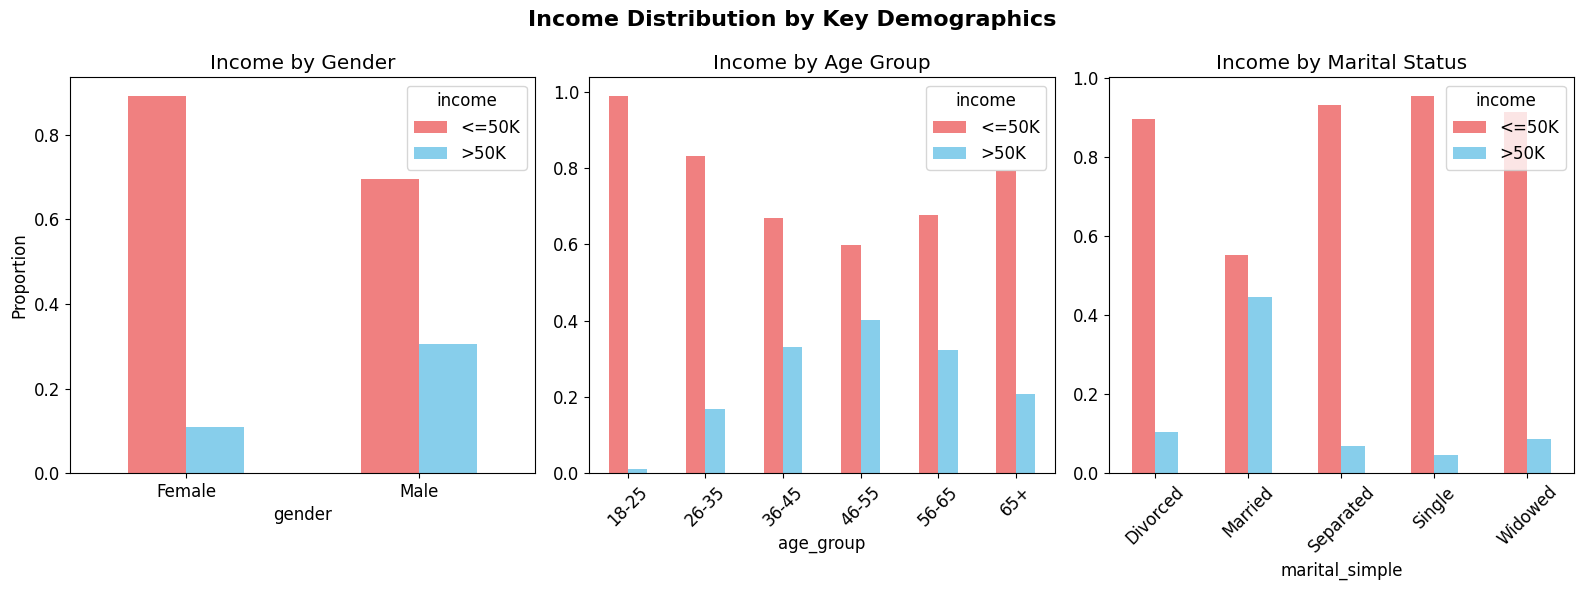

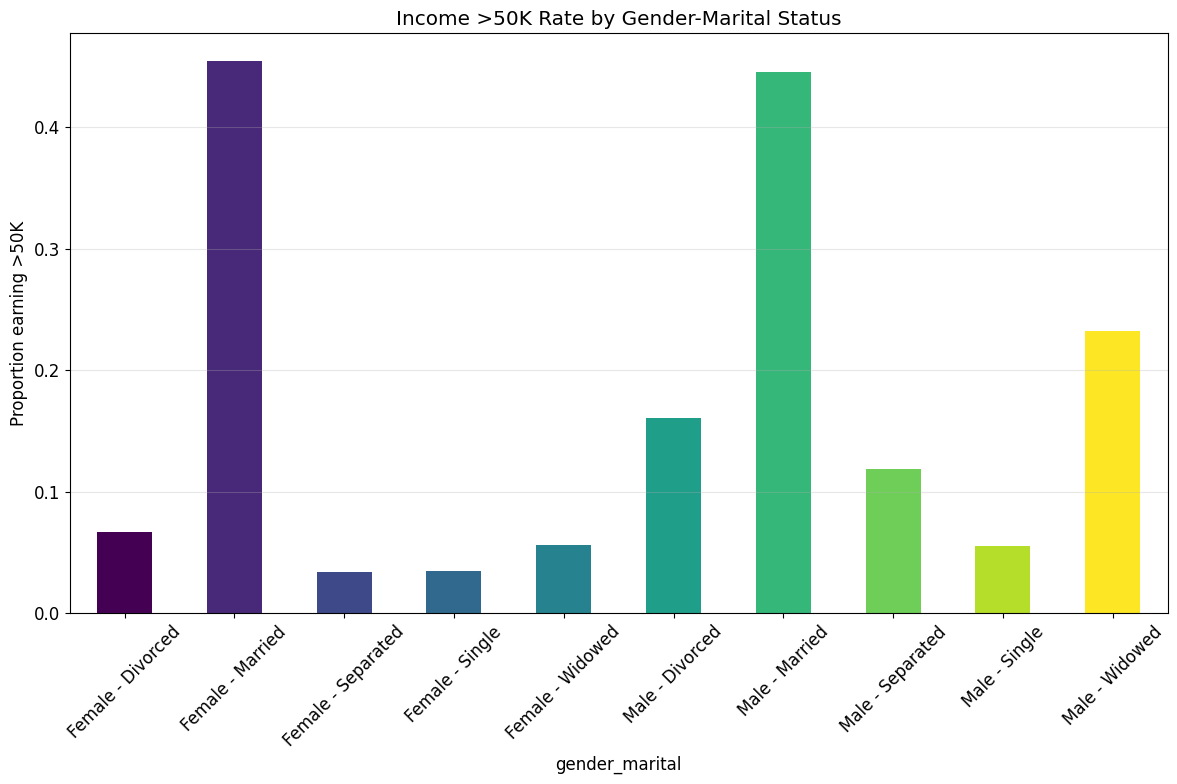


=== Comprehensive Statistical Analysis ===

1. NORMALITY TESTING (Kolmogorov-Smirnov)
age: KS-statistic = 1.0000, p-value = 0.00e+00, Normal: False
educational_num: KS-statistic = 0.9919, p-value = 0.00e+00, Normal: False
hours_per_week: KS-statistic = 0.9972, p-value = 0.00e+00, Normal: False
capital_gain: KS-statistic = 0.5000, p-value = 0.00e+00, Normal: False
capital_loss: KS-statistic = 0.5000, p-value = 0.00e+00, Normal: False

2. FEATURE DISTRIBUTION ANALYSIS

Mann-Whitney U Test Results:
age: U = 132626508.5, p = 0.00e+00, Cohen's d = 0.563
educational_num: U = 138975069.5, p = 0.00e+00, Cohen's d = 0.832
hours_per_week: U = 130260741.0, p = 0.00e+00, Cohen's d = 0.552
capital_gain: U = 114358037.0, p = 0.00e+00, Cohen's d = 0.536
capital_loss: U = 103659221.5, p = 7.02e-143, Cohen's d = 0.356

Chi-square Test Results:
gender: χ² = 1517.81, p = 0.00e+00, Cramer's V = 0.216
marital_simple: χ² = 6517.26, p = 0.00e+00, Cramer's V = 0.447
education_simple: χ² = 4313.89, p = 0.00e+

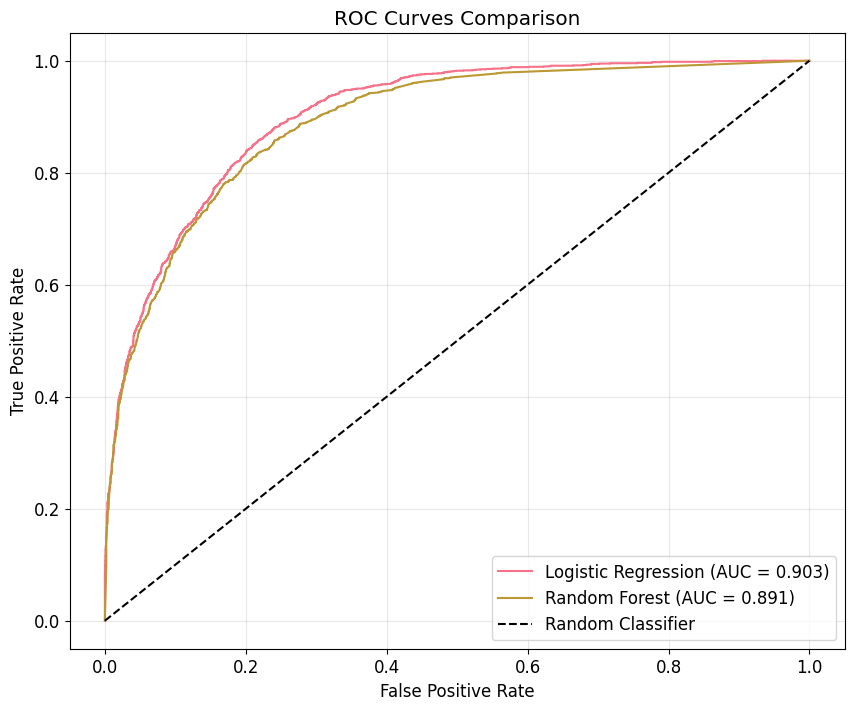


=== Advanced Model Interpretation ===
Best performing model: Logistic Regression


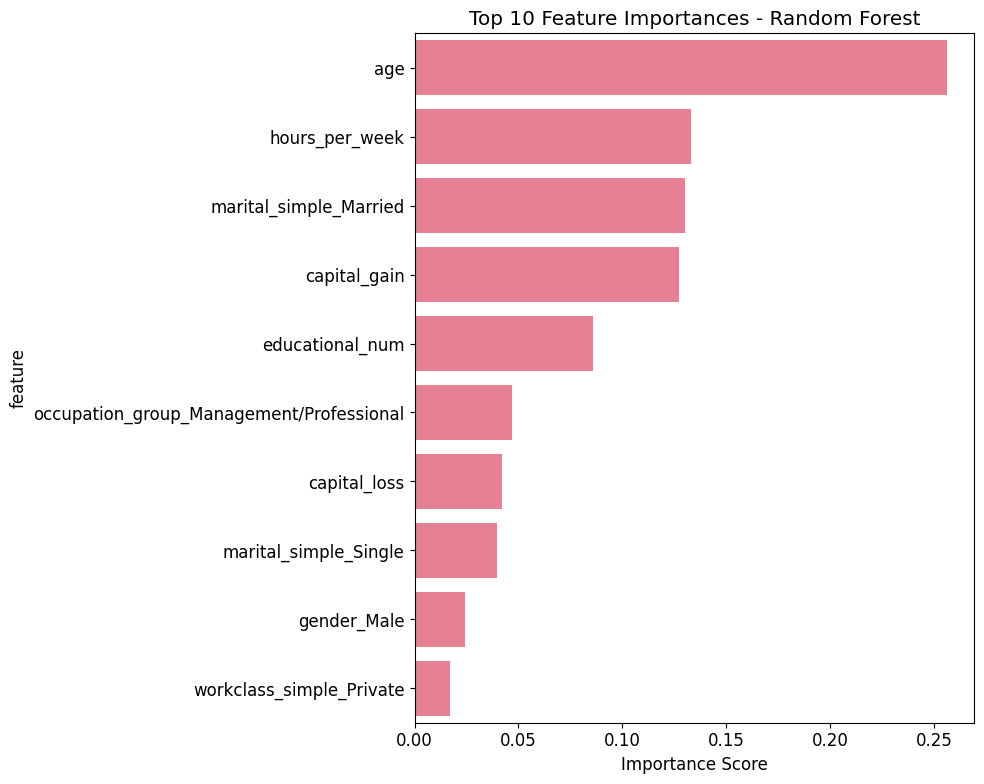


Feature Importance Analysis:
age: 0.2565
hours_per_week: 0.1329
marital_simple_Married: 0.1301
capital_gain: 0.1272
educational_num: 0.0859
occupation_group_Management/Professional: 0.0470
capital_loss: 0.0421
marital_simple_Single: 0.0395
gender_Male: 0.0242
workclass_simple_Private: 0.0169

Logistic Regression - Top 10 Coefficients:
                                 feature  coefficient
                            capital_gain     2.266954
                  marital_simple_Married     1.092786
                         educational_num     0.586403
occupation_group_Management/Professional     0.403457
                          hours_per_week     0.370041
                                     age     0.351718
                            capital_loss     0.258215
                              race_White     0.248519
                   marital_simple_Single    -0.218681
                  education_simple_No-HS    -0.196426


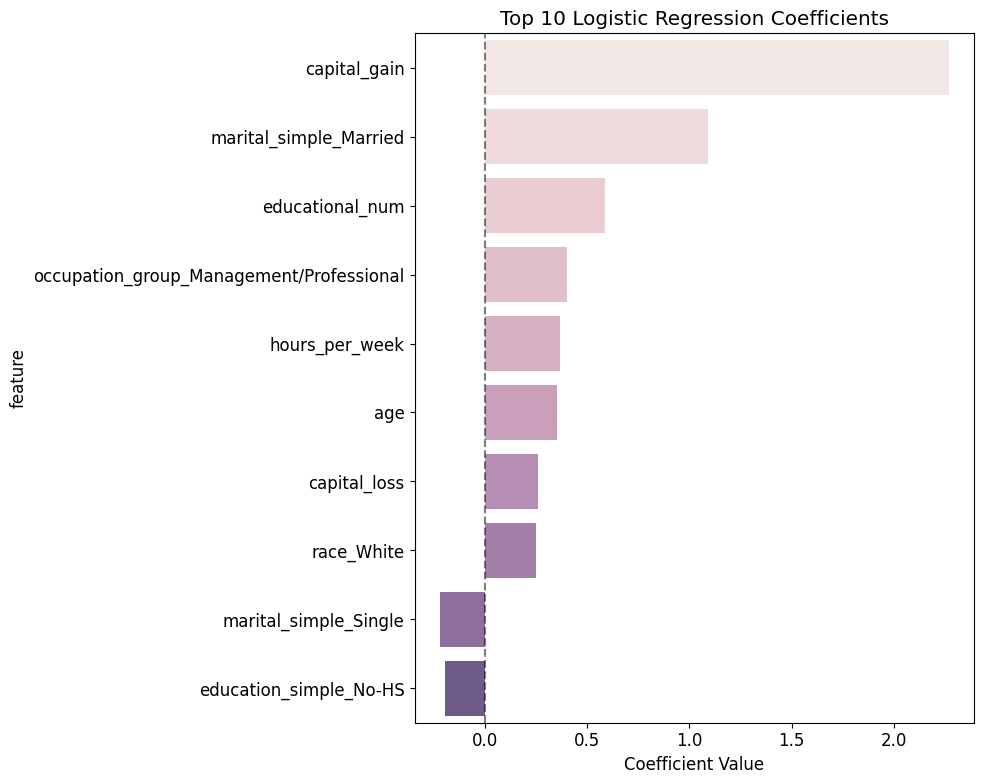


=== Advanced Statistical Tests ===

TWO-PROPORTION Z-TESTS - Men vs Women Income by Age Group

Age Group: 36-45
  Men: 5742 samples, 0.3941 high-income proportion
  Women: 2409 samples, 0.1826 high-income proportion
  Difference (Men - Women): 0.2115
  Z-statistic: 18.5034
  P-value: 0.0000
  Significant difference: True

Age Group: 46-55
  Men: 4153 samples, 0.4948 high-income proportion
  Women: 1700 samples, 0.1724 high-income proportion
  Difference (Men - Women): 0.3225
  Z-statistic: 22.8503
  P-value: 0.0000
  Significant difference: True

Age Group: 26-35
  Men: 5679 samples, 0.2018 high-income proportion
  Women: 2800 samples, 0.1004 high-income proportion
  Difference (Men - Women): 0.1014
  Z-statistic: 11.7415
  P-value: 0.0000
  Significant difference: True

Age Group: 18-25
  Men: 3062 samples, 0.0144 high-income proportion
  Women: 2508 samples, 0.0068 high-income proportion
  Difference (Men - Women): 0.0076
  Z-statistic: 2.7084
  P-value: 0.0068
  Significant differe

<Figure size 1400x800 with 0 Axes>

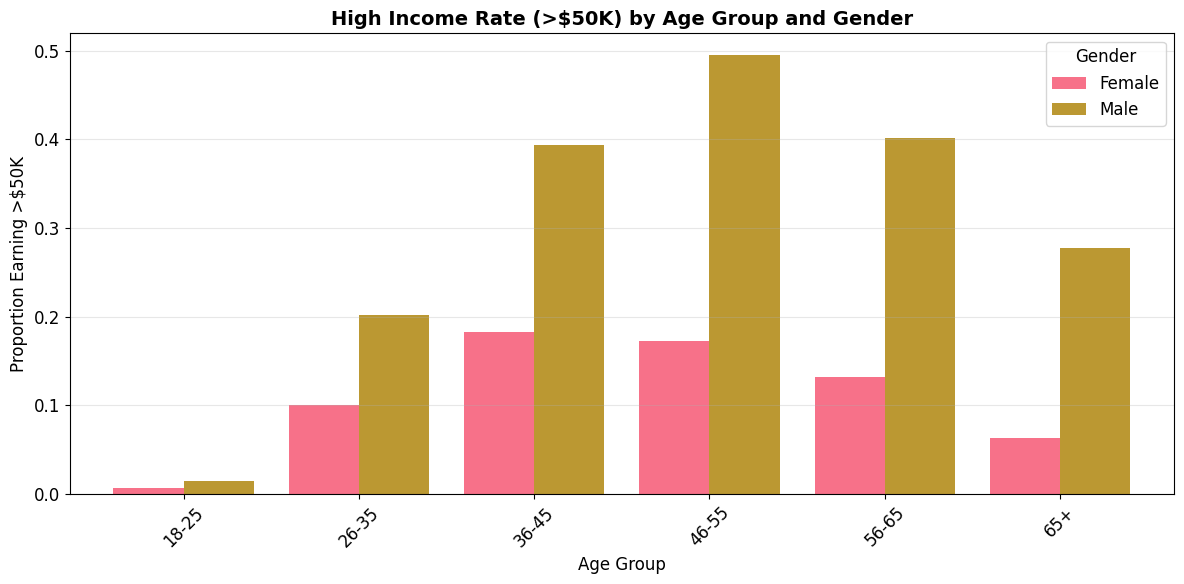


📊 COMPREHENSIVE ANALYSIS SUMMARY

🔍 Dataset Overview:
   • Total samples: 32,561
   • High income rate: 24.1%
   • Male high income rate: 30.6%
   • Female high income rate: 10.9%

📈 Key Statistical Findings:
   • Significant features (after FDR correction): 13
   • Most significant features: ['age', 'educational_num', 'hours_per_week', 'capital_gain', 'capital_loss']

👫 Gender Analysis:
   • Married male vs female income difference: -0.9%
   • Statistical significance: p = 7.57e-01

🤖 Machine Learning Results:
   • Best performing model: Logistic Regression
   • Best AUC score: 0.903

⚡ Statistical Power:
   • Analysis power: 1.000 (Adequate)

✅ Analysis completed successfully!
   All statistical tests, visualizations, and ML models have been executed.


In [229]:
# ===============================
# Execute Analysis
# ===============================

if __name__ == "__main__":
    results = main()


# ====================================================================
# Simpson's Paradox Analysis: Gender-Marital Status Distribution and Wage Gaps
# ======================================================================


=== SIMPSON'S PARADOX ANALYSIS: GENDER-MARITAL STATUS DISTRIBUTION ===

1. SAMPLE SIZE DISTRIBUTION ANALYSIS

Gender-Marital Status Distribution:
marital_simple  Divorced  Married  Separated  Single  Widowed    All
gender                                                              
Female              2672     1671        836    4767      825  10771
Male                1771    13328        607    5916      168  21790
All                 4443    14999       1443   10683      993  32561

Percentages within each gender:
marital_simple  Divorced  Married  Separated  Single  Widowed
gender                                                       
Female             0.248    0.155      0.078   0.443    0.077
Male               0.081    0.612      0.028   0.272    0.008

2. STATISTICAL TESTS FOR SIMPSON'S PARADOX

OVERALL GENDER COMPARISON:
Male high income rate: 0.306
Female high income rate: 0.109
Difference (Male - Female): 0.196
Z-statistic: 38.973, p-value: 0.00e+00
Significant difference:

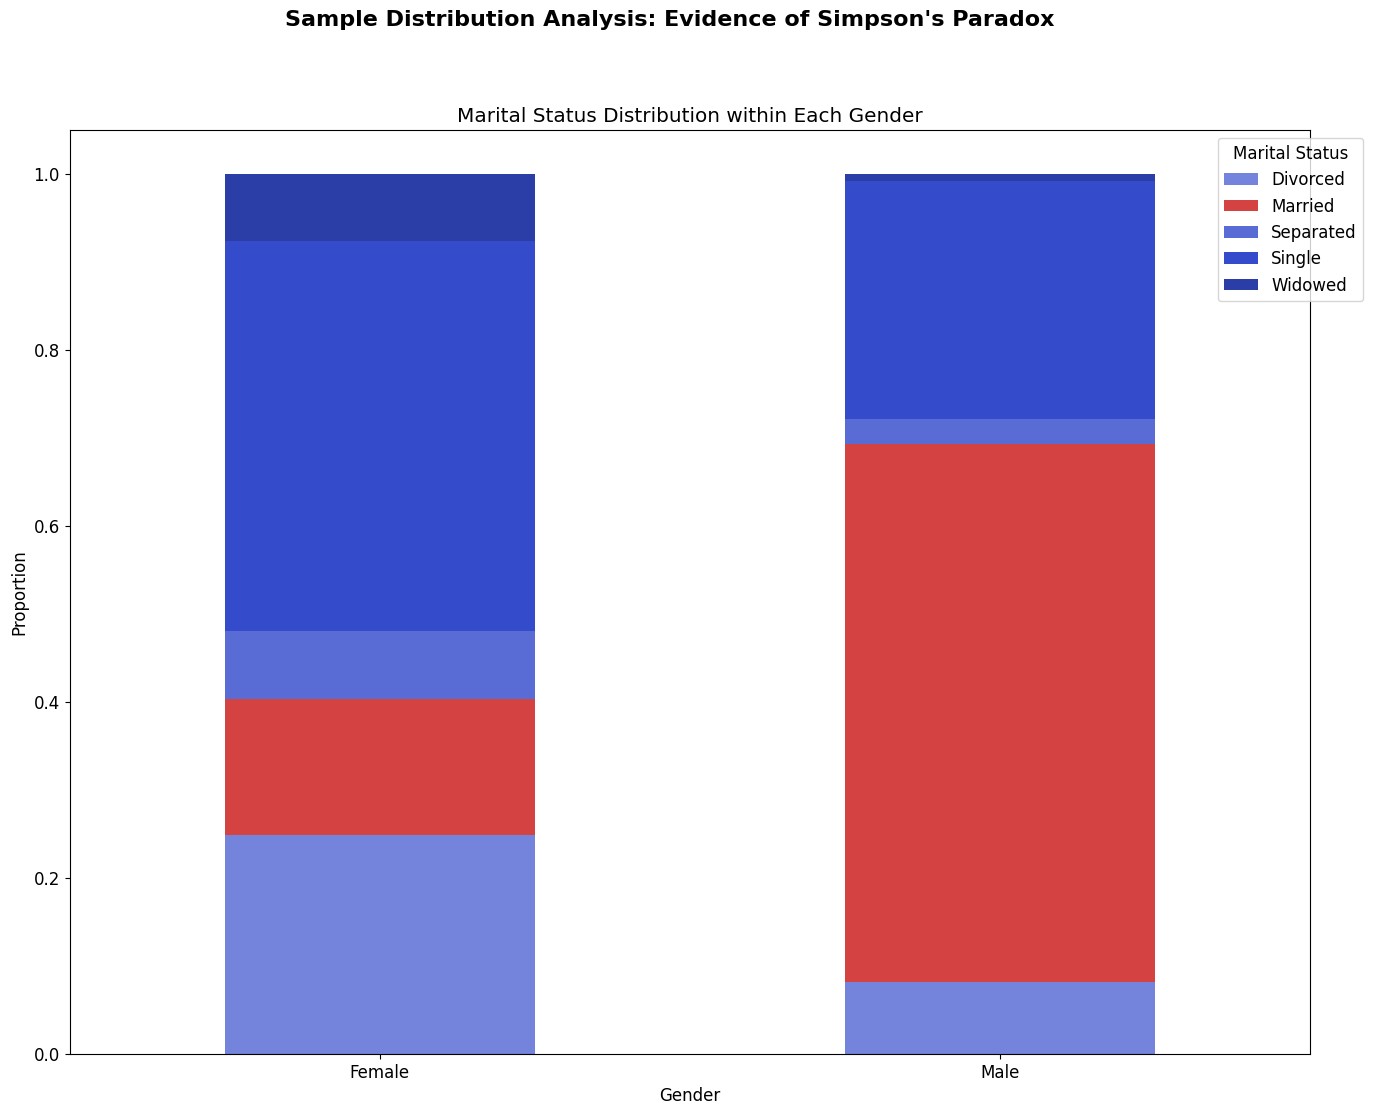

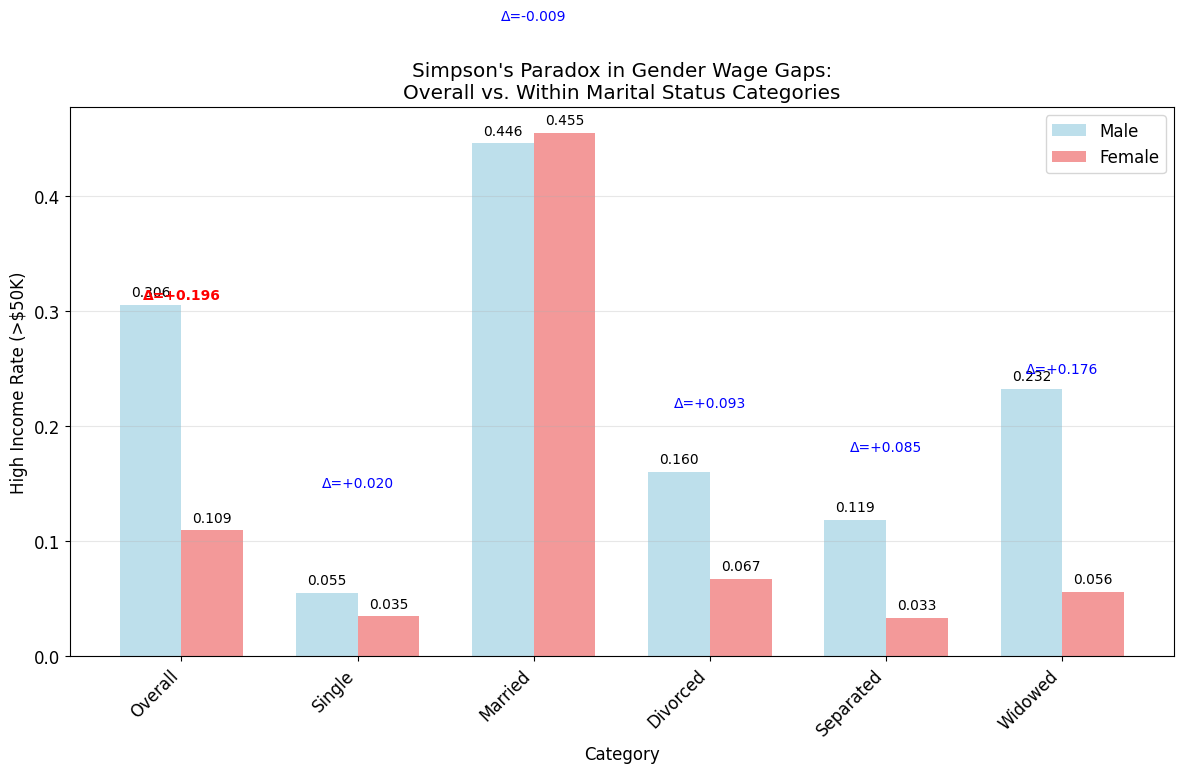

In [230]:

# =============================================================================
# Simpson's Paradox Analysis: Gender-Marital Status Distribution and Wage Gaps
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

def analyze_simpson_paradox(df):
    """
    Comprehensive analysis of Simpson's paradox in gender-marital status wage gaps
    """
    print("=== SIMPSON'S PARADOX ANALYSIS: GENDER-MARITAL STATUS DISTRIBUTION ===")

    # Set up plotting style
    plt.rcParams.update({'font.size': 12, 'figure.figsize': (12, 8)})

    # 1. CREATE COMPREHENSIVE DISTRIBUTION ANALYSIS
    print("\n1. SAMPLE SIZE DISTRIBUTION ANALYSIS")

    # Create contingency table for gender-marital status
    gender_marital_crosstab = pd.crosstab(df['gender'], df['marital_simple'], margins=True)
    print("\nGender-Marital Status Distribution:")
    print(gender_marital_crosstab)

    # Calculate percentages
    gender_marital_pct = pd.crosstab(df['gender'], df['marital_simple'], normalize='index')
    print("\nPercentages within each gender:")
    print(gender_marital_pct.round(3))

    # 2. VISUALIZE SAMPLE DISTRIBUTION
    fig, axe = plt.subplots(1, 1, figsize=(16, 12))
    fig.suptitle('Sample Distribution Analysis: Evidence of Simpson\'s Paradox',
                 fontsize=16, fontweight='bold')

    # Plot 2: Proportions within gender
    gender_marital_pct.plot(kind='bar', ax=axe, stacked=True, color=['#7483DB', '#D44242','#596BD4', '#344BCB', '#2B3DA6'])
    axe.set_title('Marital Status Distribution within Each Gender')
    axe.set_xlabel('Gender')
    axe.set_ylabel('Proportion')
    axe.tick_params(axis='x', rotation=0)
    axe.legend(title='Marital Status', bbox_to_anchor=(1.05, 1))

    # 3. STATISTICAL TESTS FOR SIMPSON'S PARADOX
    print("\n2. STATISTICAL TESTS FOR SIMPSON'S PARADOX")

    # Test 1: Overall gender difference
    male_income = df[df['gender'] == 'Male']['income_binary']
    female_income = df[df['gender'] == 'Female']['income_binary']

    overall_male_rate = male_income.mean()
    overall_female_rate = female_income.mean()
    overall_diff = overall_male_rate - overall_female_rate

    # Z-test for overall difference
    z_stat_overall, p_val_overall = proportions_ztest(
        [male_income.sum(), female_income.sum()],
        [len(male_income), len(female_income)]
    )

    print(f"\nOVERALL GENDER COMPARISON:")
    print(f"Male high income rate: {overall_male_rate:.3f}")
    print(f"Female high income rate: {overall_female_rate:.3f}")
    print(f"Difference (Male - Female): {overall_diff:.3f}")
    print(f"Z-statistic: {z_stat_overall:.3f}, p-value: {p_val_overall:.2e}")
    print(f"Significant difference: {p_val_overall < 0.05}")

    # Test 2: Within each marital status
    print(f"\nWITHIN MARITAL STATUS COMPARISONS:")

    marital_results = {}
    for marital_status in df['marital_simple'].unique():
        if pd.notna(marital_status):
            male_subset = df[(df['gender'] == 'Male') & (df['marital_simple'] == marital_status)]['income_binary']
            female_subset = df[(df['gender'] == 'Female') & (df['marital_simple'] == marital_status)]['income_binary']

            if len(male_subset) > 10 and len(female_subset) > 10:  # Minimum sample size
                male_rate = male_subset.mean()
                female_rate = female_subset.mean()
                diff = male_rate - female_rate

                # Z-test for this marital status
                z_stat, p_val = proportions_ztest(
                    [male_subset.sum(), female_subset.sum()],
                    [len(male_subset), len(female_subset)]
                )

                marital_results[marital_status] = {
                    'male_rate': male_rate,
                    'female_rate': female_rate,
                    'difference': diff,
                    'z_statistic': z_stat,
                    'p_value': p_val,
                    'male_n': len(male_subset),
                    'female_n': len(female_subset)
                }

                print(f"\n{marital_status.upper()}:")
                print(f"  Male rate: {male_rate:.3f} (n={len(male_subset)})")
                print(f"  Female rate: {female_rate:.3f} (n={len(female_subset)})")
                print(f"  Difference: {diff:.3f}")
                print(f"  Z-statistic: {z_stat:.3f}, p-value: {p_val:.4f}")
                print(f"  Significant: {p_val < 0.05}")

    # 4. SIMPSON'S PARADOX DEMONSTRATION
    print(f"\n3. SIMPSON'S PARADOX DEMONSTRATION")

    # Calculate weighted average to show the paradox
    total_male = 0
    total_female = 0
    weighted_male_rate = 0
    weighted_female_rate = 0

    print(f"\nDetailed breakdown showing Simpson's Paradox:")
    print(f"{'Marital Status':<15} {'Male Rate':<12} {'Female Rate':<14} {'Male N':<10} {'Female N':<12} {'Difference'}")
    print("-" * 80)

    for marital_status, results in marital_results.items():
        male_rate = results['male_rate']
        female_rate = results['female_rate']
        male_n = results['male_n']
        female_n = results['female_n']
        diff = results['difference']

        print(f"{marital_status:<15} {male_rate:<12.3f} {female_rate:<14.3f} {male_n:<10} {female_n:<12} {diff:>+.3f}")

        # For weighted calculation
        total_male += male_n
        total_female += female_n
        weighted_male_rate += male_rate * male_n
        weighted_female_rate += female_rate * female_n

    # Final weighted rates (should match overall rates)
    weighted_male_rate /= total_male
    weighted_female_rate /= total_female

    print("-" * 80)
    print(f"{'OVERALL':<15} {weighted_male_rate:<12.3f} {weighted_female_rate:<14.3f} {total_male:<10} {total_female:<12} {weighted_male_rate-weighted_female_rate:>+.3f}")

    # 5. STATISTICAL TEST FOR SIMPSON'S PARADOX
    print(f"\n4. FORMAL TEST FOR SIMPSON'S PARADOX")

    # Count how many marital categories show opposite direction from overall
    opposite_direction = 0
    same_direction = 0

    for marital_status, results in marital_results.items():
        category_diff = results['difference']
        if (overall_diff > 0 and category_diff < 0) or (overall_diff < 0 and category_diff > 0):
            opposite_direction += 1
        else:
            same_direction += 1

    print(f"Overall difference direction: {'Male > Female' if overall_diff > 0 else 'Female > Male'}")
    print(f"Categories with opposite direction: {opposite_direction}")
    print(f"Categories with same direction: {same_direction}")
    print(f"Simpson's Paradox detected: {opposite_direction > 0}")

    # 6. CREATE SUMMARY VISUALIZATION
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Prepare data for visualization
    categories = ['Overall'] + list(marital_results.keys())
    male_rates = [overall_male_rate] + [results['male_rate'] for results in marital_results.values()]
    female_rates = [overall_female_rate] + [results['female_rate'] for results in marital_results.values()]

    x = np.arange(len(categories))
    width = 0.35

    bars1 = ax.bar(x - width/2, male_rates, width, label='Male', color='lightblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, female_rates, width, label='Female', color='lightcoral', alpha=0.8)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    ax.set_xlabel('Category')
    ax.set_ylabel('High Income Rate (>$50K)')
    ax.set_title('Simpson\'s Paradox in Gender Wage Gaps:\nOverall vs. Within Marital Status Categories')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Add difference arrows and annotations
    for i, (male_rate, female_rate) in enumerate(zip(male_rates, female_rates)):
        diff = male_rate - female_rate
        mid_height = (male_rate + female_rate) / 2

        # Different color for overall vs within-category
        arrow_color = 'red' if i == 0 else 'blue'
        arrow_alpha = 1.0 if i == 0 else 0.7

        # Add difference annotation
        ax.annotate(f'Δ={diff:+.3f}',
                   xy=(i, mid_height),
                   xytext=(i, mid_height + 0.1),
                   ha='center', va='bottom',
                   fontweight='bold' if i == 0 else 'normal',
                   color=arrow_color, fontsize=10)

    plt.tight_layout()
    plt.show()

    return {
        'distribution_table': gender_marital_crosstab,
        'percentage_table': gender_marital_pct,
        'overall_comparison': {
            'male_rate': overall_male_rate,
            'female_rate': overall_female_rate,
            'difference': overall_diff,
            'z_statistic': z_stat_overall,
            'p_value': p_val_overall
        },
        'marital_comparisons': marital_results,
        'simpson_paradox_detected': opposite_direction > 0
    }

# Run the analysis (add this line when you run the code in your notebook)
results1 = analyze_simpson_paradox(results['data'])


# ====================================================================
# Correlations
# ======================================================================


=== Creating Comprehensive Correlation Heatmap ===
Computing correlations for 17 features...
Features included: ['gender', 'marital_simple', 'age_group', 'education_simple', 'workclass_simple', 'occupation_group', 'work_intensity', 'has_capital_gain', 'has_capital_loss', 'has_investments', 'age', 'educational_num', 'hours_per_week', 'capital_gain', 'capital_loss', 'net_capital', 'income_binary']


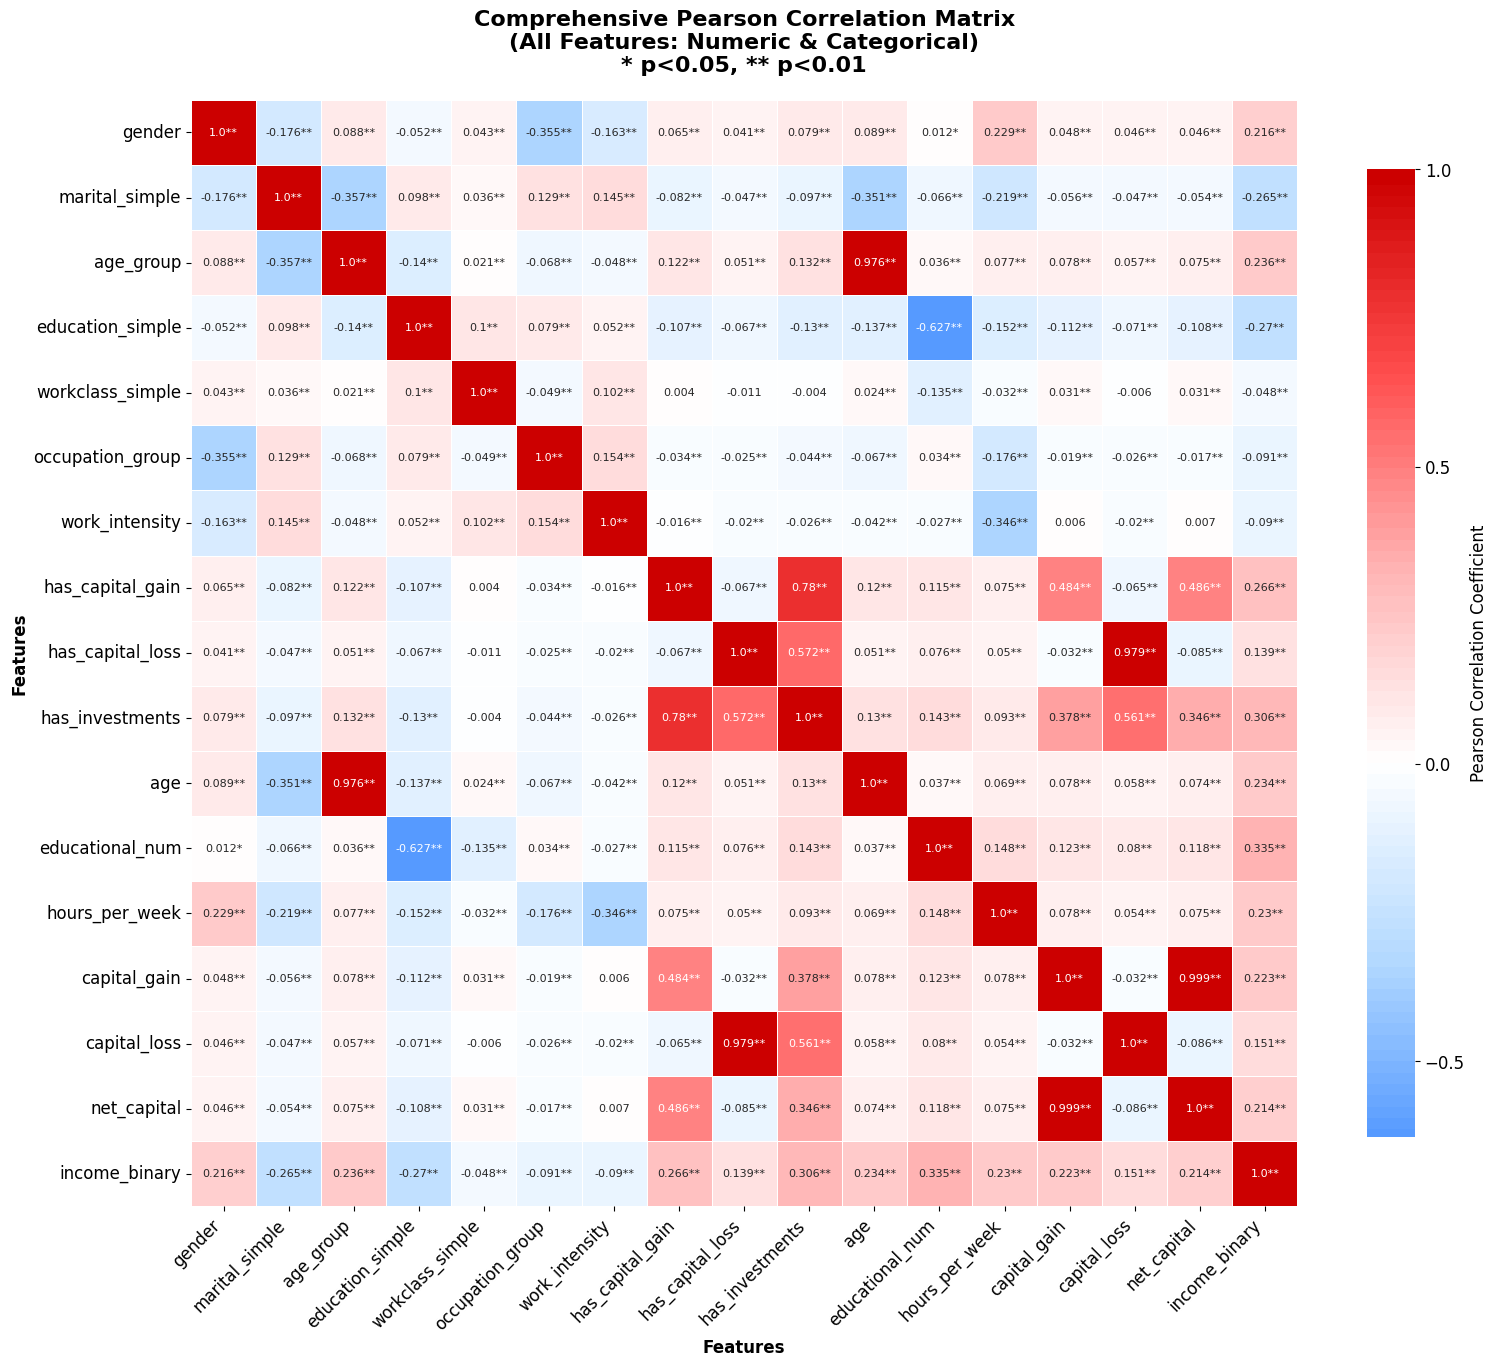


=== Correlation Summary ===
Total correlations computed: 136
Significant correlations (p<0.05): 130
Highly significant correlations (p<0.01): 129
Strong correlations (|r| > 0.5): 7
Very strong correlations (|r| > 0.7): 4

Top 10 Strongest Correlations (excluding perfect correlations):
----------------------------------------------------------------------
has_capital_loss     ↔ capital_loss         | r =  0.979** | p = 0.000e+00
age_group            ↔ age                  | r =  0.976** | p = 0.000e+00
has_capital_gain     ↔ has_investments      | r =  0.780** | p = 0.000e+00
education_simple     ↔ educational_num      | r = -0.627** | p = 0.000e+00
has_capital_loss     ↔ has_investments      | r =  0.572** | p = 0.000e+00
has_investments      ↔ capital_loss         | r =  0.561** | p = 0.000e+00
has_capital_gain     ↔ net_capital          | r =  0.486** | p = 0.000e+00
has_capital_gain     ↔ capital_gain         | r =  0.484** | p = 0.000e+00
has_investments      ↔ capital_gain       

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

def create_comprehensive_correlation_heatmap(df):
    """
    Create a comprehensive Pearson correlation heatmap for all features (numeric and categorical)
    0 = white, positive = red, negative = blue
    """
    print("=== Creating Comprehensive Correlation Heatmap ===")

    # Create a copy for processing
    df_corr = df.copy()

    # List of all relevant features (excluding raw target and redundant columns)
    features_to_include = [


        # Categorical features (will be encoded)
        'gender', 'marital_simple', 'age_group', 'education_simple',
        'workclass_simple', 'occupation_group', 'work_intensity',
        'has_capital_gain', 'has_capital_loss', 'has_investments',

        # Numeric features
        'age', 'educational_num', 'hours_per_week', 'capital_gain', 'capital_loss',
        'net_capital', 'income_binary',
    ]

    # Filter to available columns
    available_features = [col for col in features_to_include if col in df_corr.columns]
    df_subset = df_corr[available_features].copy()

    # Encode categorical variables
    label_encoders = {}
    categorical_columns = df_subset.select_dtypes(include=['object', 'category']).columns

    for col in categorical_columns:
        le = LabelEncoder()
        # Handle any NaN values and categorical constraints
        if df_subset[col].dtype.name == 'category':
            # For categorical columns, add 'Unknown' to categories first
            if df_subset[col].isnull().any():
                df_subset[col] = df_subset[col].cat.add_categories(['Unknown'])
                df_subset[col] = df_subset[col].fillna('Unknown')
            # Convert to string to avoid categorical issues with LabelEncoder
            df_subset[col] = df_subset[col].astype(str)
        else:
            # For object columns, simple fillna
            df_subset[col] = df_subset[col].fillna('Unknown')

        df_subset[col] = le.fit_transform(df_subset[col])
        label_encoders[col] = le

    # Remove any remaining NaN values
    df_subset = df_subset.dropna()

    print(f"Computing correlations for {len(df_subset.columns)} features...")
    print(f"Features included: {list(df_subset.columns)}")

    # Compute Pearson correlations with p-values
    n_features = len(df_subset.columns)
    feature_names = list(df_subset.columns)

    # Initialize matrices
    corr_matrix = np.zeros((n_features, n_features))
    p_value_matrix = np.zeros((n_features, n_features))

    # Compute correlations
    for i in range(n_features):
        for j in range(n_features):
            if i == j:
                corr_matrix[i, j] = 1.0
                p_value_matrix[i, j] = 0.0
            else:
                try:
                    corr, p_val = pearsonr(df_subset.iloc[:, i], df_subset.iloc[:, j])
                    corr_matrix[i, j] = corr
                    p_value_matrix[i, j] = p_val
                except:
                    corr_matrix[i, j] = 0.0
                    p_value_matrix[i, j] = 1.0

    # Convert to DataFrames
    corr_df = pd.DataFrame(corr_matrix, index=feature_names, columns=feature_names)
    pval_df = pd.DataFrame(p_value_matrix, index=feature_names, columns=feature_names)

    # Create significance annotations (add * for p < 0.05, ** for p < 0.01)
    annotations = corr_df.round(3).astype(str)

    # Add significance stars
    sig_01 = pval_df < 0.01
    sig_05 = (pval_df < 0.05) & (pval_df >= 0.01)

    annotations[sig_01] = annotations[sig_01] + "**"
    annotations[sig_05] = annotations[sig_05] + "*"

    # Create the heatmap
    plt.figure(figsize=(16, 14))

    # Custom colormap: white at 0, red for positive, blue for negative
    colors = ['#0066CC', '#4D94FF', '#B3D9FF', 'white', '#FFB3B3', '#FF4D4D', '#CC0000']
    n_bins = 100
    cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

    # Create heatmap
    sns.heatmap(
        corr_df,
        annot=annotations,
        fmt='',
        cmap=cmap,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={
            "shrink": 0.8,
            'label': 'Pearson Correlation Coefficient',
            'ticks': [-1, -0.5, 0, 0.5, 1]
        },
        annot_kws={'size': 8}
    )

    plt.title('Comprehensive Pearson Correlation Matrix\n(All Features: Numeric & Categorical)\n* p<0.05, ** p<0.01',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')

    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n=== Correlation Summary ===")

    # Get upper triangle (excluding diagonal)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    upper_triangle_corrs = corr_matrix[mask]
    upper_triangle_pvals = p_value_matrix[mask]

    print(f"Total correlations computed: {len(upper_triangle_corrs)}")
    print(f"Significant correlations (p<0.05): {np.sum(upper_triangle_pvals < 0.05)}")
    print(f"Highly significant correlations (p<0.01): {np.sum(upper_triangle_pvals < 0.01)}")
    print(f"Strong correlations (|r| > 0.5): {np.sum(np.abs(upper_triangle_corrs) > 0.5)}")
    print(f"Very strong correlations (|r| > 0.7): {np.sum(np.abs(upper_triangle_corrs) > 0.7)}")

    # Find strongest correlations (excluding perfect correlations)
    non_perfect = np.abs(upper_triangle_corrs) < 0.99
    if np.any(non_perfect):
        strongest_indices = np.where(mask)
        strongest_corrs = upper_triangle_corrs[non_perfect]
        strongest_pvals = upper_triangle_pvals[non_perfect]

        # Get indices of strongest correlations
        abs_corrs = np.abs(strongest_corrs)
        top_indices = np.argsort(abs_corrs)[-10:]  # Top 10

        print(f"\nTop 10 Strongest Correlations (excluding perfect correlations):")
        print("-" * 70)

        feature_pairs = [(feature_names[i], feature_names[j]) for i, j in zip(*strongest_indices)]
        valid_pairs = [pair for i, pair in enumerate(feature_pairs) if non_perfect[i]]

        for idx in reversed(top_indices):
            if idx < len(valid_pairs) and idx < len(strongest_corrs):
                pair = valid_pairs[idx]
                corr = strongest_corrs[idx]
                pval = strongest_pvals[idx]
                sig_marker = "**" if pval < 0.01 else "*" if pval < 0.05 else ""
                print(f"{pair[0]:20} ↔ {pair[1]:20} | r = {corr:6.3f}{sig_marker:2} | p = {pval:.3e}")

    return corr_df, pval_df, label_encoders

# Usage example:
corr_matrix, p_values, encoders = create_comprehensive_correlation_heatmap(results['data'])